In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)

In [ ]:
#adding new row

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/water_large.csv')

In [ ]:
from collections import namedtuple
Curve = namedtuple('Curve', ['xs', 'ys'])

def flatten(seq): return [item for subseq in seq for item in subseq]

def make_curve(clf, x_start=-50, x_end=50):
    xs = np.linspace(x_start, x_end, num=100)
    ys = clf.predict(xs.reshape(-1, 1))
    return Curve(xs, ys)

def plot_data(df=df, ax=plt, **kwargs):
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, **kwargs)

def plot_curve(curve, ax=plt, **kwargs):
    ax.plot(curve.xs, curve.ys, **kwargs)
    
def plot_curves(curves, cols=2, labels=None):
    if labels is None:
        labels = [f'Deg {deg} poly' for deg in degrees]
    rows = int(np.ceil(len(curves) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8),
                             sharex=True, sharey=True)
    for ax, curve, label in zip(flatten(axes), curves, labels):
        plot_data(ax=ax, label='Training data')
        plot_curve(curve, ax=ax, label=label)
        ax.set_ylim(-5e10, 170e10)
        ax.legend()
        
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off',
                    left='off', right='off')
    plt.grid(False)
    plt.title('Polynomial Regression')
    plt.xlabel('Water Level Change (m)')
    plt.ylabel('Water Flow (Liters)')
    plt.tight_layout()
    
def print_coef(clf):
    reg = clf.named_steps['reg']
    print(reg.intercept_)
    print(reg.coef_)

def coefs(clf):
    reg = clf.named_steps['reg']
    return np.append(reg.intercept_, reg.coef_)

def coef_table(clf):
    vals = coefs(clf)
    return (pd.DataFrame({'Coefficient Value': vals})
            .rename_axis('degree'))

In [ ]:
X = df.iloc[:, [0]].values
y = df.iloc[:, 1].values

degrees = [1, 2, 8, 12]
clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                  ('reg', LinearRegression())])
        .fit(X, y)
        for deg in degrees]

curves = [make_curve(clf) for clf in clfs]

ridge_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', Ridge(alpha=0.1, normalize=True))])
        .fit(X, y)
        for deg in degrees]

ridge_curves = [make_curve(clf) for clf in ridge_clfs]

lasso_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', LassoCV(normalize=True, precompute=True, tol=0.001))])
        .fit(X, y)
        for deg in degrees]
lasso_curves = [make_curve(clf) for clf in lasso_clfs]

# Regularização

Vamos ver primeiro a ideia intuitiva da regularização.

# Dataset

O dataset tem como variáveis a vazão de água em litros que sai de uma represa e a mudança do nível da água em metros.


In [ ]:
df.head()

,water_level_change,water_flow
0,-15.94,6.04e+10
1,-29.15,3.32e+10
2,36.19,9.73e+11
3,37.49,1.04e+12
4,-48.06,7.95e+10


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


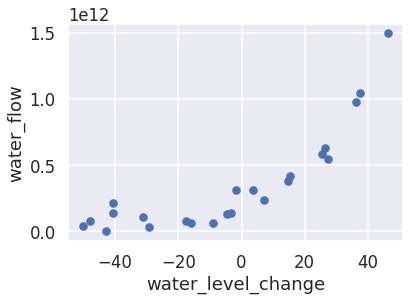

In [ ]:
df.plot.scatter(0, 1, s=50);

Usando uma regressão linear para ajustar o modelo:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


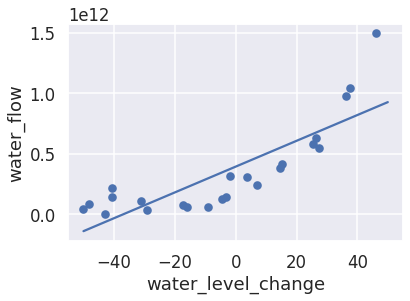

In [ ]:
df.plot.scatter(0, 1, s=50);
plot_curve(curves[0])

O modelo não capturou bem o padrão dos dados, podemos criar novas variáveis polinomiais e tentar ajustar o modelo linear:

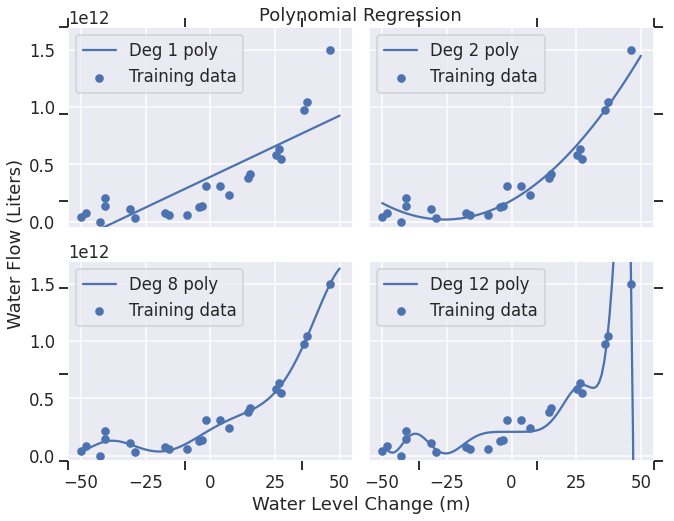

In [ ]:
plot_curves(curves)

O polinômio de grau 12 ajustou perfeitamente os dados, mas também aprendeu padrões espúrios que estão presentes no ruído. 

## Examinando os coeficientes

Examinando os coeficientes da regressão com o polinômio de grau 12:

\begin{split}
207097470825 + 1.8x + 482.6x^2 + 601.5x^3 + 872.8x^4 + 150486.6x^5 \\
    + 2156.7x^6 - 307.2x^7 - 4.6x^8 + 0.2x^9 + 0.003x^{10} - 0.00005x^{11} + 0x^{12}
\end{split}

Onde $x$ é o "water level change". Os coeficientes do modelo são bem grandes, principalmente do termo $x^5$ e $x^6$, o que aumenta a variância do modelo. 

## Penalização para os pesos

Lembre que a equação de regressão linear é dada por: $ f_\hat{\theta}(x) = \hat{\theta} \cdot x $, onde $x$ são as variáveis e $\theta$ é o vetor de parâmetros. Para fazer o ajuste do modelo, minimizamos a função de erro: 

\begin{split}
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2\\
\end{aligned}
\end{split}

Para minimizar o erro acima, procuramos o menor valor de $\hat{\theta}$ independente de quão grande são esses pesos. Entretanto, pesos grandes podem levar a uma variância grande. A ideia da regularização é incorporar um termo que penaliza os pesos. Lembrando que na equação acima $X$ representa a matriz de dados de tamanho $n\times p$, $x$ é uma linha de $X$, $y$ é um valor observados e $\hat{\theta}$ são os pesos ajustados do modelo.

## Regularização L2: Regressão Ridge

Para adicionar a penalidade nos pesos, modificamos a função de erro acrescentando um termo que penaliza os pesos altos:

\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2
\end{aligned}

Note que o termo extra $\lambda \sum_{j = 1}^{p} \hat{\theta_j}^2$ é o somatório sobre todos os parâmetros $\hat{\theta_1}, \hat{\theta_2}, \ldots, \hat{\theta_p}$. O $\lambda$ é o um escalar que ajusta a penalidade da regularização. 

Esse termo novo faz com que o erro aumente caso os parâmetros sejam muito maiores que 0 e dessa forma, o processo de otimização tenta encontrar não só os melhores pesos como também os menores valores possíveis. 

A regressão linear que usa esse termo (chamado de L2) é conhecida como **regressão ridge**.

## Parâmetro de Regularização

O $\lambda$ controla a 'importância' ou o peso do termo de regularização durante a otimização. Note que quando $\lambda = 0$ a funão de erro fica sem regularização. Geralmente esse parâmetro é encontrado com métodos de busca (em algumas implementações o lambda é chamado de alpha).

Note que o parâmetro do intercept ($\theta_0$) não é adicionado na regularização.

Também note que o termo de regularização $\lambda \sum_{j = 1}^{p} \hat{\theta_j}^2$, entretanto o valor do $\hat{\theta_j}$ depende dos dados. Considre o dataset abaixo:





In [ ]:
pd.DataFrame(clfs[2].named_steps['poly'].transform(X[:5]),
             columns=[f'deg_{n}_feat' for n in range(8)])

,deg_0_feat,deg_1_feat,deg_2_feat,deg_3_feat,deg_4_feat,deg_5_feat,deg_6_feat,deg_7_feat
0,-15.94,253.98,-4047.62,6.45e+04,-1.03e+06,1.64e+07,-2.61e+08,4.16e+09
1,-29.15,849.90,-24777.01,7.22e+05,-2.11e+07,6.14e+08,-1.79e+10,5.22e+11
2,36.19,1309.68,47396.85,1.72e+06,6.21e+07,2.25e+09,8.13e+10,2.94e+12
3,37.49,1405.66,52701.42,1.98e+06,7.41e+07,2.78e+09,1.04e+11,3.90e+12
4,-48.06,2309.65,-110999.13,5.33e+06,-2.56e+08,1.23e+10,-5.92e+11,2.85e+13


Como os parâmetros de grau 7 são muito maiores, pode ser que esses valores afetem muito mais a predição que os termos de grau 0. Se aplicarmos a regularização diretamente, o termo de regularização pode desproporcionalmente reduzir os pesos para os parâmetros de ordem mais baixa. Na prática, isso pode anular o efeito da regularização. Uma forma de impedir isso é normalizar os dados, subtraindo a média e deixando a faixa de cada variável entre -1 e 1.

# Usando Regressão Ridge

Usando o dataste anterior:

In [ ]:
df.head()

,water_level_change,water_flow
0,-15.94,6.04e+10
1,-29.15,3.32e+10
2,36.19,9.73e+11
3,37.49,1.04e+12
4,-48.06,7.95e+10


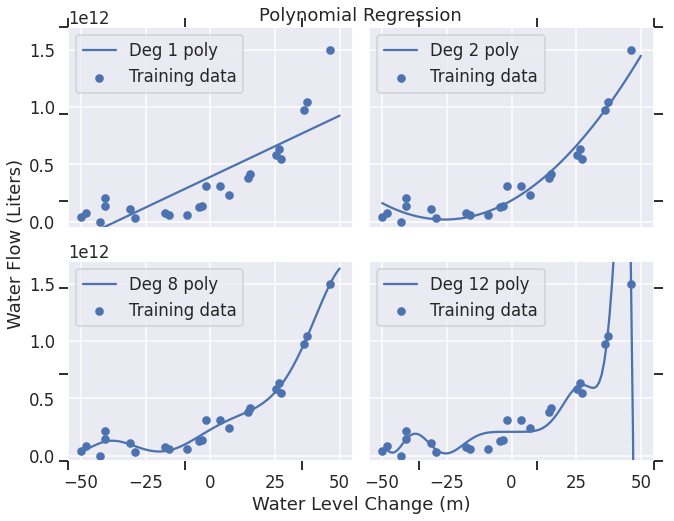

In [ ]:
plot_curves(curves)

Removendo o vetor de saída Y:

In [ ]:
X = df.iloc[:, [0]].values
y = df.iloc[:, 1].values
print('X: ')
print(X)
print()
print('y: ')
print(y)

X: 
[[-15.94]
 [-29.15]
 [ 36.19]
 ...
 [  7.09]
 [ 46.28]
 [ 14.61]]

y: 
[6.04e+10 3.32e+10 9.73e+11 ... 2.36e+11 1.49e+12 3.78e+11]


Aplicando a transformação polinomial de grau 12:

In [ ]:
X_poly_8 = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
print(X_poly_8[0:2])

[[-1.59e+01  2.54e+02 -4.05e+03  6.45e+04 -1.03e+06  1.64e+07 -2.61e+08
   4.16e+09]
 [-2.92e+01  8.50e+02 -2.48e+04  7.22e+05 -2.11e+07  6.14e+08 -1.79e+10
   5.22e+11]]


In [ ]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1.0, 10.0]

clf = RidgeCV(alphas=alphas, normalize=True).fit(X_poly_8, y)

clf.alpha_

0.1

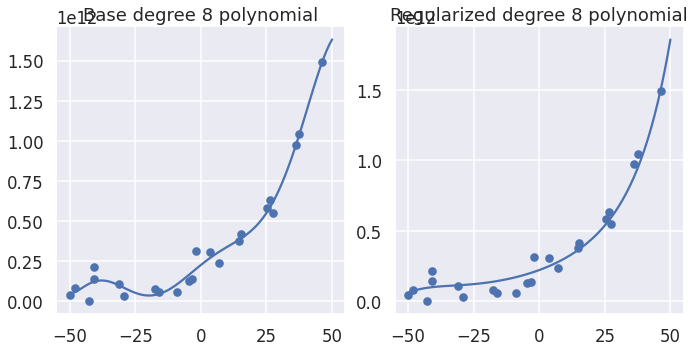

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_data()
plot_curve(curves[2])
plt.title('Base degree 8 polynomial')

plt.subplot(122)
plot_data()
plot_curve(ridge_curves[2])
plt.title('Regularized degree 8 polynomial')
plt.tight_layout()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
base = coef_table(clfs[2]).rename(columns={'Coefficient Value': 'Base'})
ridge = coef_table(ridge_clfs[2]).rename(columns={'Coefficient Value': 'Regularized'})

pd.options.display.max_rows = 20
display(base.join(ridge))
pd.options.display.max_rows = 7

,Base,Regularized
degree,,
0,225782844315.516,221063525725.229
1,13115209239.704,6846139065.959
2,-144725709.540,146158037.962
3,-10355079.765,1930090.040
4,567935.137,38240.624
5,9805.136,564.209
6,-249.637,7.252
7,-2.091,0.179
8,0.034,0.000


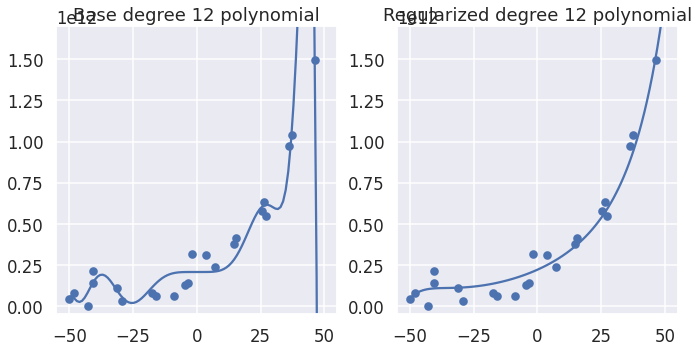

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_data()
plot_curve(curves[3])
plt.title('Base degree 12 polynomial')
plt.ylim(-5e10, 170e10)

plt.subplot(122)
plot_data()
plot_curve(ridge_curves[3])
plt.title('Regularized degree 12 polynomial')
plt.ylim(-5e10, 170e10)
plt.tight_layout()

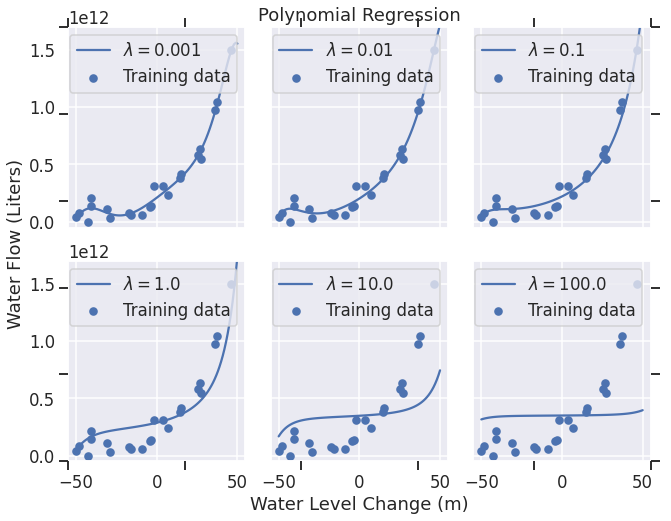

In [ ]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

alpha_clfs = [Pipeline([
    ('poly', PolynomialFeatures(degree=12, include_bias=False)),
    ('reg', Ridge(alpha=alpha, normalize=True))]
).fit(X, y) for alpha in alphas]

alpha_curves = [make_curve(clf) for clf in alpha_clfs]
labels = [f'$\\lambda = {alpha}$' for alpha in alphas]

plot_curves(alpha_curves, cols=3, labels=labels)

# Regularização L1: Lasso Regression

\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} |\hat{\theta_j}|
\end{aligned}

Lasso = Least Absolute Shinkage and Selection Operator

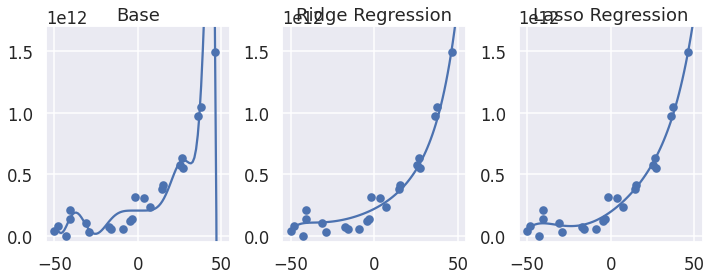

In [ ]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(131)
plot_data()
plot_curve(curves[3])
plt.title('Base')
plt.ylim(-5e10, 170e10)

plt.subplot(132)
plot_data()
plot_curve(ridge_curves[3])
plt.title('Ridge Regression')
plt.ylim(-5e10, 170e10)

plt.subplot(133)
plot_data()
plot_curve(lasso_curves[3])
plt.title('Lasso Regression')
plt.ylim(-5e10, 170e10)
plt.tight_layout()

In [ ]:
ridge = coef_table(ridge_clfs[3]).rename(columns={'Coefficient Value': 'Ridge'})
lasso = coef_table(lasso_clfs[3]).rename(columns={'Coefficient Value': 'Lasso'})

pd.options.display.max_rows = 20
pd.set_option('display.float_format', '{:.10f}'.format)
display(ridge.join(lasso))
pd.options.display.max_rows = 7
pd.set_option('display.float_format', '{:.2f}'.format)

,Ridge,Lasso
degree,,
0,221303288116.2428894043,197461304568.5928955078
1,6953405307.7654933929,9712897677.6159210205
2,142621063.9297250211,195271783.4490722120
3,1893283.0567886187,0.0000000000
4,38202.1520293690,37800.5376232511
5,484.4262914112,934.3307418246
6,8.1525126516,0.0000000000
7,0.1197232472,0.1046689492
8,0.0012506185,0.0000000000
